In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
from scipy import stats
import matplotlib
import matplotlib.animation as animation
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import warnings
warnings.filterwarnings("ignore")

In [2]:
datadir = "/net/aeolus/aura/hansingh/SOMClimos/"
myfile = "SOM_Control.cam5.0030-0059.ann.nc"
deg2rad = np.pi/180.
Re = 6.4e6
cp = 3850.
rho = 1000. #kg/m^3, for water
g = 9.8

myData_C = xr.open_dataset(datadir+myfile, decode_times=False)
mylat = np.array(myData_C.lat)
mylon = np.array(myData_C.lon)
mylev = np.array(myData_C.lev)
myilev = np.array(myData_C.ilev)
hyai = np.array(myData_C.hyai)
hybi = np.array(myData_C.hybi)

nlat = len(mylat)
nlon = len(mylon)
nlev = len(mylev)

dlev = np.zeros([nlev])
for i in range(0,nlev):
    dlev[i] = myilev[i+1]-myilev[i]
dmass = 100.*dlev/g #mass of air in each pressure level per m^2

coslat = np.cos(deg2rad*mylat)
gw = np.array(myData_C.gw)
dlat = deg2rad*(mylat[1]-mylat[0])
dA = (2.*np.pi*coslat*dlat*(Re**2))/nlon

dA_big = np.zeros([nlat, nlon])
for i in range(0,nlon):
    dA_big[:,i] = dA

In [3]:
def RobinsonMapFig(ax, myLat, myLon, myField, myConts, myCmap, myTitle):
    ax.coastlines()
    ax.gridlines()
    data_cyc, lon_cyc = add_cyclic_point(myField, coord=myLon)
    mycontourf = ax.contourf(lon_cyc, myLat, data_cyc, myConts, transform=ccrs.PlateCarree(), cmap=myCmap)
    #plt.colorbar(mycontourf)
    return mycontourf
    
def StereoMapFig(myFig, xp, yp, ip, LatEdge, myLat, myLon, myField, myConts, myCmap):
    if LatEdge>0.:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.NorthPolarStereo())
    else:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.gridlines()
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if LatEdge>0.:
        ax.set_extent([-180, 180, LatEdge, 90], ccrs.PlateCarree())
    else:
        ax.set_extent([-180, 180, -90, LatEdge], ccrs.PlateCarree())
    data_cyc, lon_cyc = add_cyclic_point(myField, coord=myLon)
    mycontour1 = ax.contourf(lon_cyc, myLat, data_cyc, myConts, transform=ccrs.PlateCarree(), cmap=myCmap, extend="both")
    return ax, mycontour1

In [4]:
import matplotlib.path as mpath
def StereoMapFig2(myFig, xp, yp, ip, LatEdge, myLat, myLon, myField, myConts, myField2, myConts2, myCmap, mycolor):
    if LatEdge>0.:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.NorthPolarStereo())
    else:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.gridlines()
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if LatEdge>0.:
        ax.set_extent([-180, 180, LatEdge, 90], ccrs.PlateCarree())
    else:
        ax.set_extent([-180, 180, -90, LatEdge], ccrs.PlateCarree())
    data_cyc, lon_cyc = add_cyclic_point(myField, coord=myLon)
    data_cyc2, lon_cyc = add_cyclic_point(myField2, coord=myLon)
    mycontour1 = ax.contourf(lon_cyc, myLat, data_cyc, myConts, transform=ccrs.PlateCarree(), cmap=myCmap, extend="both")
    mycontour2 = ax.contour(lon_cyc, myLat, data_cyc2, myConts2, transform=ccrs.PlateCarree(), colors=mycolor, linewidths=1.)
    return ax, mycontour1, mycontour2

In [5]:
mydir = "/net/aeolus/aura/kheyblom/iCESM-output/1850-iso-gridtags/cam/day/"
myfile = "1850-iso-gridtags.cam.h1.0005-01-11-00000.nc"
myData = xr.open_dataset(mydir+myfile, decode_times=False)

#Construct Column-Integrated Vapor (in m) from Total Vapor
VapByLev = np.array(myData['H2OV'])
ntime = np.shape(VapByLev)[0]
ColIntVap = np.zeros([ntime, nlat, nlon])
for i in range(0,ntime):
    ColIntVap[i,:,:] = np.sum(VapByLev[i,:,:,:]*np.expand_dims(dmass, axis=(1,2)), axis=0)/rho
    
VapTagNames = ['LAT05NV', 'LAT15NV', 'LAT25NV', 'LAT35NV', 'LAT45NV', 'LAT55NV', 'LAT65NV', 'LAT75NV', 'LAT85NV']
ntag = 9

ColIntVapTag = np.zeros([ntag, ntime, nlat, nlon])
for i in range(0,ntag):
    VapByLevTag = np.array(myData[VapTagNames[i]])
    ColIntVapTag[i,:,:,:] = np.sum(VapByLevTag[:,:,:,:]*np.expand_dims(dmass, axis=(0,2,3)), axis=1)/rho
    
VapTagLats = np.array([5., 15., 25., 35., 45., 55., 65., 75., 85.])
MeanLat = np.zeros([ntime, nlat, nlon])
for i in range(0,ntime):
    MeanLat[i,:,:] = np.sum(ColIntVapTag[:,i,:,:]*np.expand_dims(VapTagLats,axis=(1,2)), axis=0)/np.sum(ColIntVapTag[:,i,:,:],axis=0)
    

#Grab daily pressure
myData = xr.open_dataset(mydir+myfile, decode_times=False)
Press = np.array(myData['PS'])

#Grab climatological winter season pressure
myfile = "/net/aeolus/aura/hansingh/1850Tag.Climo.DJF.nc"
myData = xr.open_dataset(myfile, decode_times=False)
PressClimo = np.array(myData['PS'][0,:,:])

PressAnom = Press-np.expand_dims(PressClimo, axis=0)
PressAnom = PressAnom/100. #in hPa

MovieWriter Pillow unavailable; using Pillow instead.


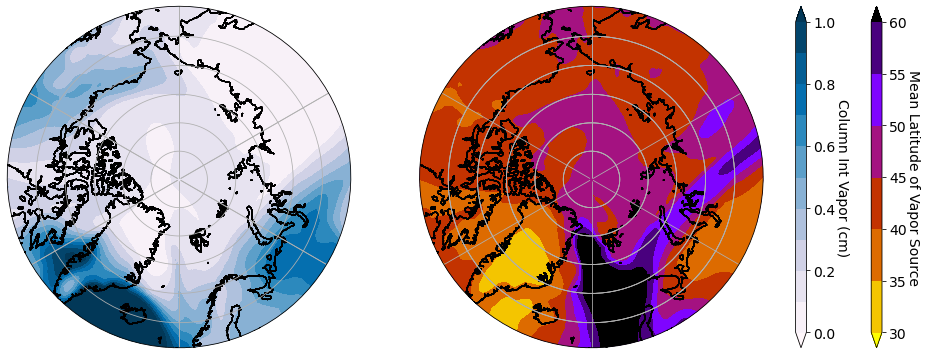

In [21]:
#Cool Pacific WMAI
myfig = plt.figure(figsize=[15,10])
myconts_lat = np.linspace(30.,60.,7)
myconts_WV = [0.5,1.]
myconts_Press = [-15., 15.]
myconts_WV2 = np.linspace(0.,1.,11)
itime0 = 0
#itime1 = 12
panstart = 1

for i in range(itime0,itime0+1):
    myax0, c10,c20 = StereoMapFig2(myfig, 1,2, panstart, 60, mylat, mylon, ColIntVap[i,:,:]*100., myconts_WV2, \
                                   PressAnom[i,:,:], myconts_Press, "PuBu", "fuchsia")
    #plt.title("Day "+str(i), fontsize=14)
    panstart = panstart+1
    
for i in range(itime0,itime0+1):
    myax, c1,c2 = StereoMapFig2(myfig, 1,2, panstart, 60, mylat, mylon, MeanLat[i,:,:], myconts_lat, \
                                ColIntVap[i,:,:]*100., myconts_WV, "gnuplot_r", "cyan")
    #plt.title("Day "+str(i), fontsize=14)
    panstart = panstart+1

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.9)

bbox_ax0 = myax0.get_position()
# fig.add_axes() adds the colorbar axes
# they're bounded by [x0, y0, x_width, y_width]
cbar_im1a_ax0 = myfig.add_axes([0.83, bbox_ax0.y0, 0.01, (bbox_ax0.y1-bbox_ax0.y0)])
cbar_im1a0 = plt.colorbar(c10, cax=cbar_im1a_ax0, extend='both')
cbar_im1a0.ax.tick_params(labelsize=14)
cbar_im1a0.ax.set_ylabel("Column Int Vapor (cm)", rotation=270, fontsize=14, labelpad=13.)

bbox_ax = myax.get_position()
# fig.add_axes() adds the colorbar axes
# they're bounded by [x0, y0, x_width, y_width]
cbar_im1a_ax = myfig.add_axes([0.9, bbox_ax.y0, 0.01, (bbox_ax.y1-bbox_ax.y0)])
cbar_im1a = plt.colorbar(c1, cax=cbar_im1a_ax, extend='both')
cbar_im1a.ax.tick_params(labelsize=14)
cbar_im1a.ax.set_ylabel("Mean Latitude of Vapor Source", rotation=270, fontsize=14, labelpad=13.)

def animate(i):
    global myax0, myax
    data_cyc, lon_cyc = add_cyclic_point(ColIntVap[i,:,:]*100., coord=mylon)
    for c in myax0.collections:
        c.remove()
    myax0.coastlines()
    myax0.gridlines()
    myax0.contourf(lon_cyc, mylat, data_cyc, myconts_WV2, transform=ccrs.PlateCarree(), \
                   cmap="PuBu", extend="both")  # update the data.
    #plt.title("Day "+str(i), fontsize=14)
    data_cyc, lon_cyc = add_cyclic_point(MeanLat[i,:,:], coord=mylon)
    for c in myax.collections:
        c.remove()
    myax.coastlines()
    myax.gridlines()
    myax.contourf(lon_cyc, mylat, data_cyc, myconts_lat, transform=ccrs.PlateCarree(), \
                  cmap="gnuplot_r", extend="both")
    #plt.title("Day "+str(i), fontsize=14)
    return myax0, myax

ani = animation.FuncAnimation(myfig, animate, frames=30, repeat=False)
#plt.show()
ani.save('ArcticIntrusions_032022.gif', writer='Pillow', fps=2)

In [30]:
#Working on the Antarctic!
mydir = "/net/aeolus/aura/kheyblom/iCESM-output/1850-iso-gridtags/cam/day/"
myfile = "1850-iso-gridtags.cam.h1.0005-01-11-00000.nc"
myData = xr.open_dataset(mydir+myfile, decode_times=False)

#Calculate dmass array
P0=1.e5
SfcPres = np.array(myData['PS'])
PresIntfc = np.expand_dims(SfcPres, axis=1)*np.expand_dims(hybi,axis=(0,2,3))+P0*np.expand_dims(hyai,axis=(0,2,3))
dPres = np.zeros([np.shape(PresIntfc)[0], nlev,nlat,nlon])
for i in range(0,nlev):
    dPres[:,i,:,:] = PresIntfc[:,i+1,:,:]-PresIntfc[:,i,:,:]
dMass = dPres/g

In [31]:
#Construct Column-Integrated Vapor (in m) from Total Vapor
VapByLev = np.array(myData['H2OV'])
ntime = np.shape(VapByLev)[0]
ColIntVap = np.zeros([ntime, nlat, nlon])
for i in range(0,ntime):
    ColIntVap[i,:,:] = np.sum(VapByLev[i,:,:,:]*dMass[i,:,:,:], axis=0)/rho
    
VapTagNames = ['LAT05SV', 'LAT15SV', 'LAT25SV', 'LAT35SV', 'LAT45SV', 'LAT55SV', 'LAT65SV', 'LAT75SV']
ntag = 8

ColIntVapTag = np.zeros([ntag, ntime, nlat, nlon])
for i in range(0,ntag):
    VapByLevTag = np.array(myData[VapTagNames[i]])
    ColIntVapTag[i,:,:,:] = np.sum(VapByLevTag*dMass, axis=1)/rho
    
VapTagLats = np.array([5., 15., 25., 35., 45., 55., 65., 75.])
MeanLat = np.zeros([ntime, nlat, nlon])
for i in range(0,ntime):
    MeanLat[i,:,:] = np.sum(ColIntVapTag[:,i,:,:]*np.expand_dims(VapTagLats,axis=(1,2)), axis=0)/np.sum(ColIntVapTag[:,i,:,:],axis=0)

MovieWriter Pillow unavailable; using Pillow instead.


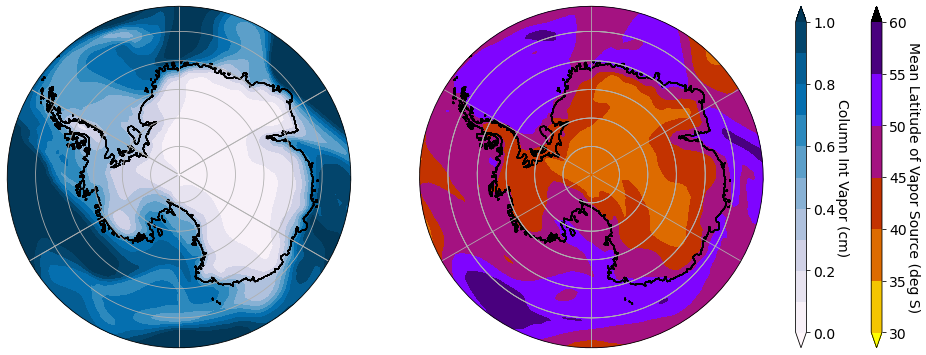

In [36]:
myfig = plt.figure(figsize=[15,10])
myconts_lat = np.linspace(30.,60.,7)
myconts_WV = [0.5,1.]
myconts_Press = [-15., 15.]
myconts_WV2 = np.linspace(0.,1.,11)
itime0 = 0
#itime1 = 12
panstart = 1

for i in range(itime0,itime0+1):
    myax0, c10 = StereoMapFig(myfig, 1,2, panstart, -60, mylat, mylon, ColIntVap[i,:,:]*100., myconts_WV2, \
                                   "PuBu")
    #plt.title("Day "+str(i), fontsize=14)
    panstart = panstart+1
    
for i in range(itime0,itime0+1):
    myax, c1 = StereoMapFig(myfig, 1,2, panstart, -60, mylat, mylon, MeanLat[i,:,:], myconts_lat, \
                                "gnuplot_r")
    #plt.title("Day "+str(i), fontsize=14)
    panstart = panstart+1

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.9)

bbox_ax0 = myax0.get_position()
# fig.add_axes() adds the colorbar axes
# they're bounded by [x0, y0, x_width, y_width]
cbar_im1a_ax0 = myfig.add_axes([0.83, bbox_ax0.y0, 0.01, (bbox_ax0.y1-bbox_ax0.y0)])
cbar_im1a0 = plt.colorbar(c10, cax=cbar_im1a_ax0, extend='both')
cbar_im1a0.ax.tick_params(labelsize=14)
cbar_im1a0.ax.set_ylabel("Column Int Vapor (cm)", rotation=270, fontsize=14, labelpad=13.)

bbox_ax = myax.get_position()
# fig.add_axes() adds the colorbar axes
# they're bounded by [x0, y0, x_width, y_width]
cbar_im1a_ax = myfig.add_axes([0.9, bbox_ax.y0, 0.01, (bbox_ax.y1-bbox_ax.y0)])
cbar_im1a = plt.colorbar(c1, cax=cbar_im1a_ax, extend='both')
cbar_im1a.ax.tick_params(labelsize=14)
cbar_im1a.ax.set_ylabel("Mean Latitude of Vapor Source (deg S)", rotation=270, fontsize=14, labelpad=13.)

def animate(i):
    global myax0, myax
    data_cyc, lon_cyc = add_cyclic_point(ColIntVap[i,:,:]*100., coord=mylon)
    for c in myax0.collections:
        c.remove()
    myax0.coastlines()
    myax0.gridlines()
    myax0.contourf(lon_cyc, mylat, data_cyc, myconts_WV2, transform=ccrs.PlateCarree(), \
                   cmap="PuBu", extend="both")  # update the data.
    #plt.title("Day "+str(i), fontsize=14)
    data_cyc, lon_cyc = add_cyclic_point(MeanLat[i,:,:], coord=mylon)
    for c in myax.collections:
        c.remove()
    myax.coastlines()
    myax.gridlines()
    myax.contourf(lon_cyc, mylat, data_cyc, myconts_lat, transform=ccrs.PlateCarree(), \
                  cmap="gnuplot_r", extend="both")
    #plt.title("Day "+str(i), fontsize=14)
    return myax0, myax

ani = animation.FuncAnimation(myfig, animate, frames=30, repeat=False)
#plt.show()
ani.save('AntarcticIntrusions_Jan_032022.gif', writer='Pillow', fps=2)

In [15]:
#Working on the Antarctic, Winter!
mydir = "/net/aeolus/aura/kheyblom/iCESM-output/1850-iso-gridtags/cam/day/"
myfiles = ["1850-iso-gridtags.cam.h1.0005-07-10-00000.nc",\
           "1850-iso-gridtags.cam.h1.0005-08-09-00000.nc",\
           "1850-iso-gridtags.cam.h1.0005-09-08-00000.nc"]
myData = xr.open_dataset(mydir+myfile, decode_times=False)
nfiles = len(myfiles)
ntime = nfiles*30

#Calculate dmass array
P0=1.e5
dPres = np.zeros([ntime,nlev,nlat,nlon])

for i in range(0,nfiles):
    myData = xr.open_dataset(mydir+myfiles[i], decode_times=False)
    SfcPres = np.array(myData['PS'])
    PresIntfc = np.expand_dims(SfcPres, axis=1)*np.expand_dims(hybi,axis=(0,2,3))+P0*np.expand_dims(hyai,axis=(0,2,3))
    for j in range(0,nlev):
        dPres[i*30:(i+1)*30,j,:,:] = PresIntfc[:,j+1,:,:]-PresIntfc[:,j,:,:]
        
dMass = dPres/g

#Construct Column-Integrated Vapor (in m) from Total Vapor
ColIntVap = np.zeros([ntime, nlat, nlon])
for i in range(0,nfiles):
    myData = xr.open_dataset(mydir+myfiles[i], decode_times=False)
    VapByLev = np.array(myData['H2OV'])
    for j in range(0,30):
        ColIntVap[i*30+j,:,:] = np.sum(VapByLev[j,:,:,:]*dMass[i*30+j,:,:,:], axis=0)/rho
    
VapTagNames = ['LAT05SV', 'LAT15SV', 'LAT25SV', 'LAT35SV', 'LAT45SV', 'LAT55SV', 'LAT65SV', 'LAT75SV']
ntag = 8
ColIntVapTag = np.zeros([ntag, ntime, nlat, nlon])

for i in range(0,nfiles):
    myData = xr.open_dataset(mydir+myfiles[i], decode_times=False)
    for j in range(0,ntag):
        VapByLevTag = np.array(myData[VapTagNames[j]])
        ColIntVapTag[j,i*30:(i+1)*30,:,:] = np.sum(VapByLevTag*dMass[i*30:(i+1)*30,:,:,:], axis=1)/rho
    
VapTagLats = np.array([5., 15., 25., 35., 45., 55., 65., 75.])
MeanLat = np.zeros([ntime, nlat, nlon])
for i in range(0,ntime):
    MeanLat[i,:,:] = np.sum(ColIntVapTag[:,i,:,:]*np.expand_dims(VapTagLats,axis=(1,2)), axis=0)/np.sum(ColIntVapTag[:,i,:,:],axis=0)

In [16]:
def StereoMapFigLog(myFig, xp, yp, ip, LatEdge, myLat, myLon, myField, myConts, myCmap):
    if LatEdge>0.:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.NorthPolarStereo())
    else:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.gridlines()
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if LatEdge>0.:
        ax.set_extent([-180, 180, LatEdge, 90], ccrs.PlateCarree())
    else:
        ax.set_extent([-180, 180, -90, LatEdge], ccrs.PlateCarree())
    data_cyc, lon_cyc = add_cyclic_point(myField, coord=myLon)
    print(data_cyc.min())
    print(data_cyc.max())
    mycontour1 = ax.pcolormesh(lon_cyc, myLat, data_cyc, transform=ccrs.PlateCarree(), cmap=myCmap, \
                             norm=matplotlib.colors.LogNorm(vmin=data_cyc.min(), vmax=1.))#, norm=matplotlib.colors.LogNorm())
    return ax, mycontour1

0.01159251107115977
7.168311348850101


MovieWriter Pillow unavailable; using Pillow instead.


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


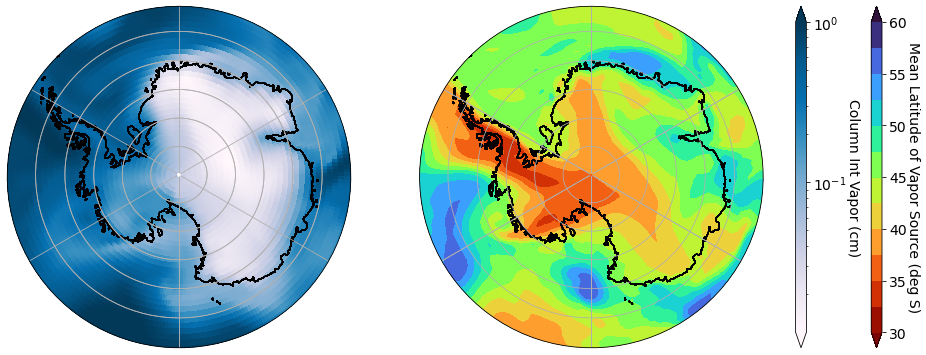

In [17]:
myfig = plt.figure(figsize=[15,10])
myconts_lat = np.linspace(30.,60.,13)
myconts_WV2 = np.linspace(0., 1., 21)
itime0 = 0
#itime1 = 12
panstart = 1

for i in range(itime0,itime0+1):
    myax0, c10 = StereoMapFigLog(myfig, 1,2, panstart, -60, mylat, mylon, ColIntVap[i,:,:]*100., myconts_WV2, \
                                   "PuBu")
    #plt.title("Day "+str(i), fontsize=14)
    panstart = panstart+1
    
for i in range(itime0,itime0+1):
    myax, c1 = StereoMapFig(myfig, 1,2, panstart, -60, mylat, mylon, MeanLat[i,:,:], myconts_lat, \
                                "turbo_r")
    #data_cyc2, lon_cyc = add_cyclic_point(ColIntVap[i,:,:]*100., coord=mylon)
    #c2 = myax.contour(lon_cyc, mylat, data_cyc2, [0.1], transform=ccrs.PlateCarree(), \
    #                  colors="chartreuse", linewidths=1.)
    #plt.title("Day "+str(i), fontsize=14)
    panstart = panstart+1

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.9)

bbox_ax0 = myax0.get_position()
# fig.add_axes() adds the colorbar axes
# they're bounded by [x0, y0, x_width, y_width]
cbar_im1a_ax0 = myfig.add_axes([0.83, bbox_ax0.y0, 0.01, (bbox_ax0.y1-bbox_ax0.y0)])
cbar_im1a0 = plt.colorbar(c10, cax=cbar_im1a_ax0, extend='both')
cbar_im1a0.ax.tick_params(labelsize=14)
cbar_im1a0.ax.set_ylabel("Column Int Vapor (cm)", rotation=270, fontsize=14, labelpad=13.)

bbox_ax = myax.get_position()
# fig.add_axes() adds the colorbar axes
# they're bounded by [x0, y0, x_width, y_width]
cbar_im1a_ax = myfig.add_axes([0.9, bbox_ax.y0, 0.01, (bbox_ax.y1-bbox_ax.y0)])
cbar_im1a = plt.colorbar(c1, cax=cbar_im1a_ax, extend='both')
cbar_im1a.ax.tick_params(labelsize=14)
cbar_im1a.ax.set_ylabel("Mean Latitude of Vapor Source (deg S)", rotation=270, fontsize=14, labelpad=13.)

def animate(i):
    global myax0, myax
    data_cyc, lon_cyc = add_cyclic_point(ColIntVap[i,:,:]*100., coord=mylon)
    for c in myax0.collections:
        c.remove() #remove old data from the figure
    myax0.coastlines()
    myax0.gridlines()
    print(i)
    myax0.pcolormesh(lon_cyc, mylat, data_cyc, transform=ccrs.PlateCarree(), \
                   cmap="PuBu", \
                   norm=matplotlib.colors.LogNorm(vmin=data_cyc.min(), vmax=1.))#, norm=matplotlib.colors.LogNorm())  # update the data.
    #plt.title("Day "+str(i), fontsize=14)
    data_cyc, lon_cyc = add_cyclic_point(MeanLat[i,:,:], coord=mylon)
    data_cyc2, lon_cyc = add_cyclic_point(ColIntVap[i,:,:]*100., coord=mylon)
    for c in myax.collections:
        c.remove()
    myax.coastlines()
    myax.gridlines()
    myax.contourf(lon_cyc, mylat, data_cyc, myconts_lat, transform=ccrs.PlateCarree(), \
                  cmap="turbo_r", extend="both")
    #myax.contour(lon_cyc, mylat, data_cyc2, [0.1], transform=ccrs.PlateCarree(), \
    #             colors="chartreuse", linewidths=1.)
    #plt.title("Day "+str(i), fontsize=14)
    return myax0, myax

ani = animation.FuncAnimation(myfig, animate, frames=90, repeat=False)
#plt.show()
ani.save('AntarcticIntrusions_JulAugSep_032022.gif', writer='Pillow', fps=2)